# Standard methods for anomaly detection

TBD: introduction

## Wine dataset

Wine dataset is a quite popular and it contains **178** different observations, each described with **13** continuous variables with the following meaning:

1. Alcohol
2. Malic acid
3. Ash
4. Alcalinity of ash
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavanoid phenols
9. Proanthocyanins
10. Color intensity
11. Hue
12. OD280/OD315 of diluted wines
13. Proline 

In [1]:
%matplotlib inline

import pandas as pd

wine_df = pd.read_csv("./dataset/wine/wine.data")
wine_df.head().T

,1,1,1,1,1
alcohol,14.23,13.20,13.16,14.37,13.24
malic_acid,1.71,1.78,2.36,1.95,2.59
ash,2.43,2.14,2.67,2.50,2.87
alcalinity_of_ash,15.60,11.20,18.60,16.80,21.00
magnesium,127.00,100.00,101.00,113.00,118.00
total_phenols,2.80,2.65,2.80,3.85,2.80
flavanoids,3.06,2.76,3.24,3.49,2.69
nonflavanoid_phenols,0.28,0.26,0.30,0.24,0.39
proanthocyanins,2.29,1.28,2.81,2.18,1.82
color_intensity,5.64,4.38,5.68,7.80,4.32


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50477badd8>,
      dtype=object)

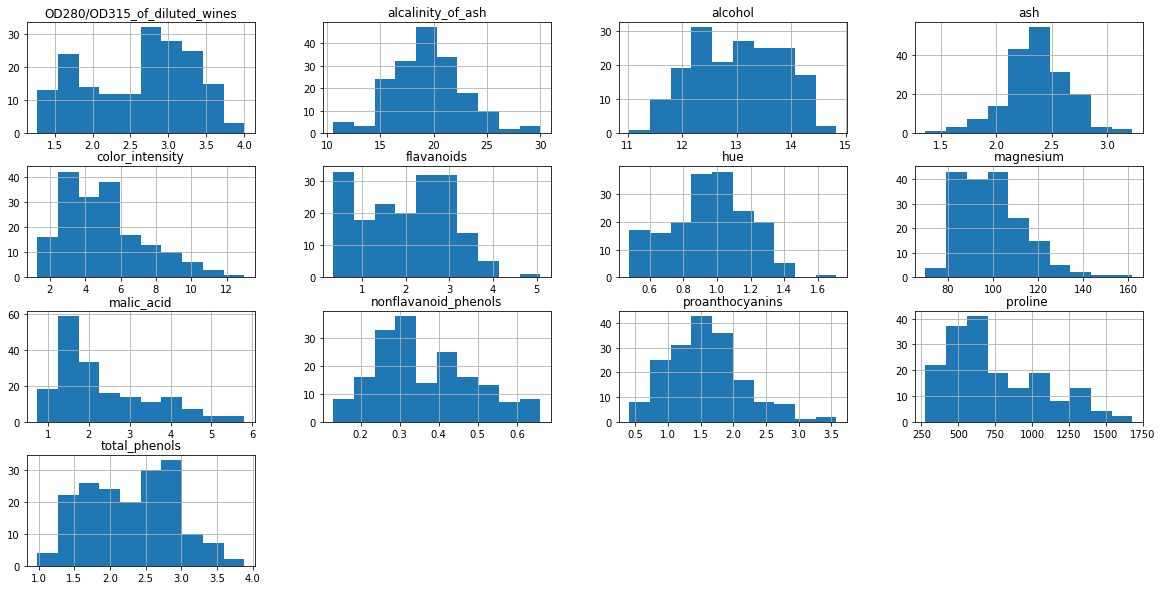

In [6]:
wine_df.hist(figsize=(20,10))

## Normal / Gaussian distribution

TBD: short description (mean, variance, standard deviation, intuitions)

## Z-score / normal score